# Evaluación de redes profundas convolucionales para la segmentación semántica de imágenes aéreas  - Arquitectura SegNet 

**Estudiante**: Gizela Andrea Guzmán Lugo

Fecha: 26/09/2025

A continuación se presenta una implementación en PyTorch de una red totalmente convolucional para la segmentación semántica de imágenes aéreas, utilizando la arquitectura SegNet [http://mi.eng.cam.ac.uk/projects/segnet/]

Se utilizo el conjunto de datos de etiquetado semántico 2D de ISPRS [https://www.isprs.org/resources/datasets/benchmarks/UrbanSemLab/2d-sem-label-vaihingen.aspx?utm_source=chatgpt.com]. El conjunto de datos de prueba se capturó sobre Vaihingen, Alemania. Este conjunto de datos es un subconjunto de los datos utilizados para la prueba de cámaras aéreas digitales realizada por la Asociación Alemana de Fotogrametría y Teledetección. Consta de tres áreas de prueba para las que se dispone de datos de referencia de diversas clases de objetos.

**Objetivo**: Interpretar automáticamente las fotografias áereas clasificando cada píxel en varias clases:

* Carreteras
* Edificios
* Vegetación baja
* Árboles
* Carros
* Desorden
  

Este trabajo es una implementación de PyTorch de la línea base presentada en ["Más allá de RGB: teledetección urbana de muy alta resolución con redes profundas multimodales "](https://hal.archives-ouvertes.fr/hal-01636145), *Nicolas Audebert*, *Bertrand Le Saux* y *Sébastien Lefèvre*, ISPRS Journal, 2018.


## Requisitos

Este notebook requiere algunas bibliotecas útiles, como `torch`, `scikit-image`, `numpy` y `matplotlib`. Las cuales se instalalan por medio de pip install -r requirements.txt

Donde requirements_py310.txt es un archivo de texto que contiene la lista de librerías necesarias junto con sus versiones compatibles, optimizadas para Python 3.10.0.

Además, se recomienda ejecutar el notebook en una GPU para acelerar el procesamiento. Para ello, PyTorch (torch) se configura con soporte CUDA/cuDNN, lo que permite aprovechar las capacidades de cómputo paralelo de la tarjeta gráfica.


In [1]:
# Configuración directorio de trabajo

import os

# Ruta local en Windows
base_path = r"F:\PERCEPCION_R_AVANZADA\Vaihingen"

# Cambiar directorio de trabajo
os.chdir(base_path)

print("Directorio actual:", os.getcwd())


Directorio actual: F:\PERCEPCION_R_AVANZADA\Vaihingen


In [2]:
# Instalación paquetes listados en requirements_py310.txt

import sys
!{sys.executable} -m pip install -r requirements_py310.txt

In [3]:
# Importación librerias 
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
import os, glob, re
from tqdm.auto import tqdm

## Parámetros

Se establecen parámetros básicos como el tamaño de los parches de imagen, el stride (cuánto se desplaza la ventana al generar parches), el número de canales de las imágenes, la ruta base del dataset y el tamaño de batch para entrenamiento.

Se definen las clases que el modelo debe predecir (carreteras, edificios, vegetación, árboles, autos, objetos diversos); se calcula el número de clases (N_CLASSES); y se asignan pesos iguales para todas las clases. 



In [4]:
# Parametros
WINDOW_SIZE = (256, 256) # Tamaño del patch en píxeles para entrenar/inferir.
STRIDE = 32 # Paso de la ventana para entrenar/inferir.
IN_CHANNELS = 3 # Número de canales de entrada (RGB/IRRG).
FOLDER = "F:/PERCEPCION_R_AVANZADA/" # Ruta conjunto de datos
BATCH_SIZE = 10 # Número de muestras por mini-batch

LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Orden y nombres de clases
N_CLASSES = len(LABELS) # Número de clases
WEIGHTS = torch.ones(N_CLASSES) # Pesos para el equilibrio de clases
CACHE = True # Almacenar el conjunto de datos en la memoria

# Selección del conjunto de datos
DATASET = 'Vaihingen'

if DATASET == 'Potsdam':
    MAIN_FOLDER = FOLDER + 'Potsdam/'
    DATA_FOLDER = MAIN_FOLDER + '2_Ortho_RGB/top_potsdam_{}_RGB.tif'
    LABEL_FOLDER = MAIN_FOLDER + '5_Labels_for_participants/top_potsdam_{}_label.tif'
    ERODED_FOLDER = MAIN_FOLDER + '5_Labels_for_participants_no_Boundary/top_potsdam_{}_label_noBoundary.tif'
elif DATASET == 'Vaihingen':
    MAIN_FOLDER = FOLDER + 'Vaihingen/'
    DATA_FOLDER = MAIN_FOLDER + 'ISPRS_semantic_labeing_Vaihingen_ground_truth_eroded_for_participants/top/top_mosaic_09cm_area{}.tif'
    LABEL_FOLDER = MAIN_FOLDER + 'ISPRS_semantic_labeing_Vaihingen_ground_truth_eroded_for_participants/gts_for_participants/top_mosaic_09cm_area{}.tif'
    ERODED_FOLDER = MAIN_FOLDER + 'ISPRS_semantic_labeing_Vaihingen_ground_truth_eroded_for_participants/gts_eroded_for_participants/top_mosaic_09cm_area{}_noBoundary.tif'

## Visualización del conjunto de datos

Se realiza una inspección visual de las imágenes IRRG y sus etiquetas para verificar coherencia geométrica y cromática. Primero, se verica que se pueda acceder al conjunto de datos, se usa ```scikit-image``` para la manipulación de imágenes.

Como el conjunto de datos ISPRS se almacena con una verdad fundamental en formato RGB, se necesita definir la paleta de colores que pueda asignar el ID de la etiqueta a su color RGB. Para ello se definen dos funciones auxiliares para convertir de valores numéricos a colores y viceversa.



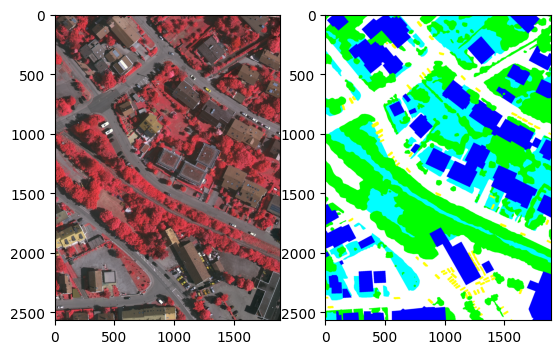

Ground truth in numerical format has shape (2566,1893) : 
 [[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]


In [5]:
# Paleta de colores ISPRS
palette = {0 : (255, 255, 255), # Superficies impermeables -vías (blanco)
           1 : (0, 0, 255),     # Edificios (azul)
           2 : (0, 255, 255),   # Vegetación baja (cian)
           3 : (0, 255, 0),     # Árboles (verde)
           4 : (255, 255, 0),   # Carros (amarillo)
           5 : (255, 0, 0),     # Desorden (rojo)
           6 : (0, 0, 0)}       # Indefinido (negro)

# invierte el dict para hacer color → índice.
invert_palette = {v: k for k, v in palette.items()}

# Convierte una máscara numérica (HxW con valores 0..6) a RGB aplicando la paleta por clase
def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

# Convierte una máscara en color (HxWx3) a índices comparando píxel a píxel con cada color de la paleta
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# Carga y visualización imagen
img = io.imread('F:/PERCEPCION_R_AVANZADA/Vaihingen/ISPRS_semantic_labeing_Vaihingen_ground_truth_eroded_for_participants/top/top_mosaic_09cm_area11.tif')
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img)

# Carga y visualización imagen con etiquetas (verdad fundamental)
gt = io.imread('F:/PERCEPCION_R_AVANZADA/Vaihingen/ISPRS_semantic_labeing_Vaihingen_ground_truth_eroded_for_participants/gts_for_participants/top_mosaic_09cm_area11.tif')
fig.add_subplot(122)
plt.imshow(gt)
plt.show()

# Conversión de la verdad fundamental en un formato de matriz
array_gt = convert_from_color(gt)
print("Ground truth in numerical format has shape ({},{}) : \n".format(*array_gt.shape[:2]), array_gt)

## Creación de funciones

* get_random_pos: elige coordenadas para recortar un parche aleatorio de tamaño w×h dentro de una imagen grande; se usa en entrenamiento para muestrear posiciones diversas.

* CrossEntropy2d: adapta Cross-Entropy a tensores 2D/4D de segmentación (N,C,H,W); aplana logits y etiquetas para calcular la pérdida por píxel.

* accuracy: precisión global en porcentaje (%) comparando predicción y verdad terreno.

* sliding_window / count_sliding_window: generan/contabilizan ventanas deslizantes (con step/stride) para recorrer imágenes completas en prueba/inferencia. Ajustan bordes para cubrir toda la imagen.

* grouper: parte un iterador en lotes de tamaño n (procesar ventanas por batch y ahorrar memoria).

* metrics: imprime matriz de confusión, Accuracy, F1 por clase y Kappa a partir de predicciones y etiquetas; útil para evaluación rápida.

In [6]:
# Devuelve coordenadas para recortar un patch aleatorio w×h dentro de img
def get_random_pos(img, window_shape):
    """ Extracto de un parche aleatorio 2D de forma window_shape en la imagen """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

# Adapta cross_entropy a tensores 2D (clasificación) 
def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ Versión 2D de la pérdida de entropía cruzada """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

# Precisión global [%] con NumPy.
def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size
    
# Genera coordenadas (fila, col) y tamaño del patch al recorrer con “stride”.
def sliding_window(top, step=10, window_size=(20,20)):
    """ Desliza una ventana window_shape a través de la imagen  """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
# Cuenta cuántas ventanas se generan
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Cuenta el número de ventanas en una imagen """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

# Corta en partes un iterador en lotes de tamaño n (útil para procesar ventanas por lotes).
def grouper(n, iterable):
    """ Explora un iterador por fragmento de n elementos """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

# Función que imprime y devuelve métricas básicas:
#Matriz de confusión multi-clase, Accuracy global, F1 por clase (macro sin promedio final) y Kappa
def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(gts.ravel().astype(np.int64),
                      predictions.ravel().astype(np.int64),
                      labels=np.arange(len(label_values), dtype=np.int64))

    print("Confusion matrix :")
    print(cm)

    print("---")

    # Calculó de la precisión global
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))

    print("---")

    # Cálculo F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")

    # Calcular el coeficiente kappa
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

## Cargue y preprocesamiento del conjunto de datos

En esta sección se define la clase ISPRS_dataset, implementada a partir de ```torch.utils.data.Dataset```, la cual gestiona la preparación del conjunto ISPRS Vaihingen para el entrenamiento y validación del modelo. La clase se encarga de leer los mosaicos de imágenes y sus etiquetas, normalizar los valores en el rango [0, 1] y convertir las etiquetas de colores a valores numéricos por clase. Dado que los mosaicos tienen una resolución muy alta, se extraen parches aleatorios de 128 × 128 píxeles, lo que permite procesar la información de manera eficiente en la GPU.

Adicionalmente, se incorpora un módulo de aumento de datos que aplica transformaciones simples como volteos horizontales y verticales, con el fin de incrementar la variabilidad de las muestras y mejorar la capacidad de generalización de la red. De esta manera, cada vez que el modelo solicita una muestra, la clase entrega un par (imagen, etiqueta) ya preprocesado y listo para ser utilizado en el entrenamiento o en la evaluación.


In [7]:
# Clase de conjunto de datos

# Define cómo se generan parches aleatorios para entrenar a partir de las tiles ISPRS

class ISPRS_dataset(torch.utils.data.Dataset):
#__init__ — el “constructor”
# Se ejecuta una sola vez cuando se crea el objeto
# Sirve para configurar tu clase: guardar parámetros, preparar rutas, crear capas, etc
    
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                            cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()

        self.augmentation = augmentation
        self.cache = cache

        # Lista de archivos
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Comprobación: genera un error si algunos archivos no existen
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))

        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}


    def __len__(self):
        # El tamaño de época predeterminado es 10 000 muestras
        return 10000

    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True

        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))

        return tuple(results)
        
# __getitem__ — acceso por índice
# Define qué devuelve el objeto cuando se hace obj[i].
    
    def __getitem__(self, i):
        # Elige una imagen al azar
        random_idx = random.randint(0, len(self.data_files) - 1)

        # # Si el mosaico aún no se ha cargado, póngalo en caché
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Los datos están normalizados en [0, 1]
            data = 1/255 * np.asarray(io.imread(self.data_files[random_idx]).transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data

        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else:
            # Las etiquetas se convierten de RGB a sus valores numéricos
            label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
            if self.cache:
                self.label_cache_[random_idx] = label

        # Obtener un parche aleatorio
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]

        # Aumento de datos
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Devuelve los valores del torch.Tensor
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))

## Definición de red

Se define la red totalmente convolucional basada en la arquitectura SegNet. Se Podría usar cualquier otra red como reemplazo directo, siempre que la salida tenga dimensiones (N_CLASES, W, H), donde W y H son las dimensiones de la ventana deslizante (es decir, la red debe conservar las dimensiones espaciales).

1. Encoder (5 bloques): aplica secuencias Conv→BN→ReLU y luego MaxPool2d con return_indices=True.

* Produce mapas cada vez más pequeños (divide H y W entre 2 por bloque) y más profundos (más canales).

* Guarda los índices del máximo (mask1..mask5) para saber dónde estaban los máximos en cada 2×2 al comprimir.

2. Decoder (5 bloques): para cada bloque, hace MaxUnpool2d usando el mask correspondiente (reconstruye la geometría), y después Conv→BN→ReLU para refinar y re-llenar la información.

* Va recuperando el tamaño espacial original (multiplica H y W por 2 por bloque) y reduce canales de forma simétrica.

3. Cabeza de clasificación: última conv produce out_channels = N_CLASSES → logits por píxel (un score por clase).


In [8]:
class SegNet(nn.Module):
    # Red SegNet 
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)

    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)

        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)

        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)

        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)

        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)

        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)

        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)

        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)

        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)

        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)

        self.apply(self.weight_init)

# Define el recorrido de datos por la red
    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)

        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)

        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)

        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)

        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)

        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))

        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))

        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))

        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))

        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x), dim=1)
        return x

Después se instancia la red usando los parámetros especificados. Por defecto, los pesos se inicializarán usando la política [He policy](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf).

In [9]:
# instanciar la red
net = SegNet()

## Descarga de pesos pre-entrenados

Se descarga y se carga los pesos preentrenados de VGG-16 en ImageNet. Este paso es opcional, pero acelera la convergencia de la red. Se omiten pesos de VGG-16 que no tienen contraparte en SegNet.


In [10]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Descarga pesos VGG-16 desde PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth', weights_only=True, map_location='cpu')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))
        
try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignora claves faltantes
    pass

Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.weight to conv1_1_bn.num_batches_tracked
Mapping features.3.bias to conv1_2.weight
Mapping features.4.weight to conv1_2.bias
Mapping features.4.bias to conv1_2_bn.weight
Mapping features.4.running_mean to conv1_2_bn.bias
Mapping features.4.running_var to conv1_2_bn.running_mean
Mapping features.7.weight to conv1_2_bn.running_var
Mapping features.7.bias to conv1_2_bn.num_batches_tracked
Mapping features.8.weight to conv2_1.weight
Mapping features.8.bias to conv2_1.bias
Mapping features.8.running_mean to conv2_1_bn.weight
Mapping features.8.running_var to conv2_1_bn.bias
Mapping features.10.weight to conv2_1_bn.running_mean
Mapping features.10.bias to conv2_1_bn.running_var
Mapping fe

## Cargue de la red en la GPU

In [11]:
import sys, torch
print(sys.executable)
print("CUDA:", torch.cuda.is_available(), " build:", torch.version.cuda)

C:\Users\USER\anaconda3\envs\torchgpu\python.exe
CUDA: True  build: 12.1


In [12]:
net.cuda()

SegNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1_bn): BatchNorm2d(256, eps=1e-05, mom

## Cargue de datos

Se crea una división de entrenamiento/prueba. Para este caso se especifica una división fija de entrenamiento/prueba para la demostración.

In [13]:

if DATASET == 'Potsdam':
    all_files = sorted(glob.glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = ["".join(f.split('')[5:7]) for f in all_files]
elif DATASET == 'Vaihingen':
    #all_ids =
    all_files = sorted(glob.glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = [f.split('area')[-1].split('.')[0] for f in all_files]

if DATASET != 'Vaihingen':
    # Números de mosaicos aleatorios para la división de entrenamiento/prueba
    train_ids = random.sample(all_ids, 2 * len(all_ids) // 3 + 1)
    test_ids = list(set(all_ids) - set(train_ids))
else:
    # Ejemplo de una división entrenamiento y prueba en Vaihingen
    train_ids = ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
    test_ids = ['5', '21', '15', '30']


print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)

train_set = ISPRS_dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)

Tiles for training :  ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
Tiles for testing :  ['5', '21', '15', '30']


## Diseño del optimizador

Se utiliza el algoritmo estándar de Descenso de Gradiente Estocástico para optimizar los pesos de la red.

El codificador se entrena a la mitad de la tasa de aprendizaje del decodificador, ya que se utilizan los pesos VGG-16 preentrenados. Se utiliza ``torch.optim.lr_scheduler`` para reducir la tasa de aprendizaje en 10 después de 25, 35 y 45 épocas.

Aprendizaje con LR diferenciado.

* Decoder (*_D): lr = 0.01 porque se inicializa aleatorio y necesita aprender más rápido.

* Encoder (resto): lr = 0.005 porque parte de pesos preentrenados VGG-16 y solo se optimiza.

El optimizador es SGD con momentum 0.9 y weight_decay=5e-4 para regularizar. Un scheduler MultiStepLR reduce la LR en las épocas 25, 35 y 45 (γ=0.1) para afinar al final.


In [14]:
base_lr = 0.01
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

## Función de testeo

Se crea una función para realizar la inferencia del modelo sobre el conjunto de imágenes de prueba usando un esquema sliding-window con stride configurable y procesamiento por lotes. Para cada imagen:
1) Carga la ortoimagen y sus etiquetas
2) Extrae parches, los envía a la red en GPU y acumula los logits en la cuadrícula de salida para promediar las zonas de solape
3) Obtiene la predicción final por argmax y muestra un panel de progreso con imagen, predicción en color y etiqueta
4) Actualiza las métricas globales (exactitud y matriz de confusión asociada)

In [15]:
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Utiliza la red en el conjunto de pruebas
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    all_preds = []
    all_gts = []
    
    # Cambiar la red al modo de inferencia
    net.eval()

    for img, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    fig = plt.figure()
                    fig.add_subplot(1,3,1)
                    plt.imshow(np.asarray(255 * img, dtype='uint8'))
                    fig.add_subplot(1,3,2)
                    plt.imshow(convert_to_color(_pred))
                    fig.add_subplot(1,3,3)
                    plt.imshow(gt)
                    clear_output()
                    plt.show()
                    
            # Construir el tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
            
            # Hacer la inferencia
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Completa la matriz de resultados
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Muestra el resultado
        clear_output()
        fig = plt.figure()
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,3)
        plt.imshow(gt)
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt_e)

        clear_output()
        
        # Calcula algunas métricas
        metrics(pred.ravel(), gt_e.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy

## Bucle de entrenamiento

Pone el modelo en modo train y recorre lotes del train_loader. Pasa cada batch por la red (output = net(data)), calcula la pérdida por píxel (CrossEntropy2d), hace backprop (loss.backward()) y actualiza con el optimizador.

Guarda el historial de pérdidas y muestra cada ~100 iteraciones: imagen IRRG, GT y predicción para monitoreo, más una curva de pérdida media. Cada save_epoch valida con test(...) (ventana deslizante, promedio de logits) y guarda checkpoint .pt. Al final, guarda segnet_final_v2.

El scheduler baja el learning rate al final de cada época si corresponde.

In [16]:

from IPython.display import clear_output

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 5):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    weights = weights.cuda()

    criterion = nn.NLLLoss2d(weight=weights)
    iter_ = 0
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            output = net(data)
            loss = CrossEntropy2d(output, target, weight=weights)
            loss.backward()
            optimizer.step()
            
            losses[iter_] = loss.item()

            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            if iter_ % 100 == 0:
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.item(), accuracy(pred, gt)))
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(convert_to_color(gt))
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(convert_to_color(pred))
                plt.show()
            iter_ += 1
            
            del(data, target, loss)
            
        if e % save_epoch == 0:
            # Validación con el mayor paso (stride) posible para una computación más rápida
            acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
            torch.save(net.state_dict(), './segnet256_epoch{}_{}'.format(e, acc))
    torch.save(net.state_dict(), './segnet_final_v2')

## Entrenamiento de la red

Se entrena la red durante 50 épocas. El gráfico de `matplotlib` se actualiza periódicamente con el gráfico de pérdidas y una inferencia de muestra.

In [17]:
train(net, optimizer, 50, scheduler)

Confusion matrix :
[[1162067   34704   48106   13433    5854       0]
 [ 104926 1078777   14073    3106     592      59]
 [  68558   20081  718413  151568     558     609]
 [   8564     440   37432  928283       1      14]
 [   8693    1590     628     288   44846       0]
 [      0       0       0       0       0       0]]
---
4456263 pixels processed
Total accuracy : 88.2440286850215%
---
F1Score :
roads: 0.8881004458588017
buildings: 0.9231658554848371
low veg.: 0.8079141314377384
trees: 0.8962804116226033
cars: 0.8312819752354119
clutter: 0.0
---
Kappa: 0.8435933421989708
Confusion matrix :
[[4351485  188371  173675   62772   24203    3859]
 [ 220449 5116824   63571   14947    2208    4948]
 [ 195800   67281 2228467  405111    1014    5037]
 [  52944   10130  381390 3948061     207      28]
 [  22151    6913    1043     638  117314     618]
 [    331     323    5561       0       1       0]]
---
17677675 pixels processed
Total accuracy : 89.16416327373368%
---
F1Score :
roads: 0.90

## Testeo de la Red

Una vez finalizado el entrenamiento, se cargan los pesos finales y se prueba la red con un paso (stride) razonable, por ejemplo, la mitad o un cuarto del tamaño de la ventana. 

In [18]:
state_dict = torch.load("./segnet_final_v2", weights_only=True)
net.load_state_dict(state_dict)

<All keys matched successfully>

In [19]:
_, all_preds, all_gts = test(net, test_ids, all=True, stride=32)

Confusion matrix :
[[1173290   31026   42090   13955    3792      11]
 [  98807 1087563   11655    3070     438       0]
 [  63345   19805  732777  143628      49     183]
 [   6790     319   36024  931601       0       0]
 [   8602    2027     538     297   44581       0]
 [      0       0       0       0       0       0]]
---
4456263 pixels processed
Total accuracy : 89.08388037241069%
---
F1Score :
roads: 0.8973544148026117
buildings: 0.9286389759007596
low veg.: 0.8220190916785343
trees: 0.9012796977678452
cars: 0.8499308898527239
clutter: 0.0
---
Kappa: 0.8547305707722964
Confusion matrix :
[[4396566  169505  156553   62765   17678    1298]
 [ 191104 5169751   46792   12632    1455    1213]
 [ 179473   58733 2284438  376540     550    2976]
 [  46622    9306  361609 3975106     113       4]
 [  24928    5942     629     737  115920     521]
 [    819       0    5397       0       0       0]]
---
17677675 pixels processed
Total accuracy : 90.1803036881264%
---
F1Score :
roads: 0.91

## Guardar resultados

Visualización y almacenamiento de los resultados para una evaluación cualitativa.

In [20]:
a = np.asarray(all_preds[0])
print("shape:", a.shape, "dtype:", a.dtype, "min/max:", a.min(), a.max())

shape: (2557, 1887) dtype: int64 min/max: 0 5


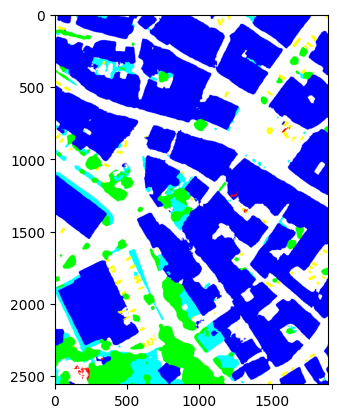

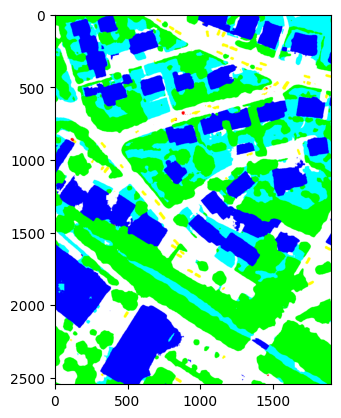

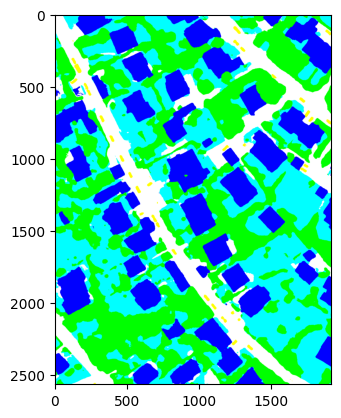

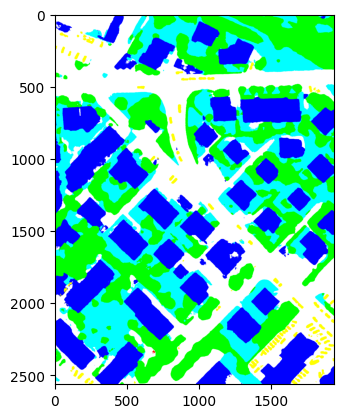

In [21]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

for p, id_ in zip(all_preds, test_ids):
    a = np.asarray(p)  # p puede ser (H,W) o (N,H,W)

    # caso 1: ya es una máscara 2D
    if a.ndim == 2:
        masks = [a]
        suffixes = [""]

    # caso 2: viene como lote (N,H,W) -> iteramos cada una
    elif a.ndim == 3:
        masks = [a[i] for i in range(a.shape[0])]
        suffixes = [f"_{i:03d}" for i in range(a.shape[0])]

    else:
        raise ValueError(f"Forma inesperada: {a.shape}")

    for y, suf in zip(masks, suffixes):
        img = convert_to_color(y).astype(np.uint8)  # y es (H,W) con labels 0..4
        plt.imshow(img); plt.show()
        io.imsave('./inference_v2_tile_{}.png'.format(id_), img)
